<a href="https://colab.research.google.com/github/metdinov/statstests/blob/master/Statistical_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats as stats

alt.renderers.enable('notebook')
np.random.seed(42)

In [2]:
def generate_sample(dist, all_params, size):
  distributions = {"Normal": stats.norm, 
                 "Exponential": stats.expon,
                 "Beta": stats.beta,
                 "Student t": stats.t,
                 "Generalized Pareto": stats.genpareto,
                 "Gamma": stats.gamma,
                 "Erlang": stats.erlang}
  
  params = []
  if dist == "Student t":
    params.append(all_params["df"])
  elif dist == "Beta":
    params.append(all_params["alpha"])
    params.append(all_params["beta"])
  elif dist == "Generalized Pareto":
    params.append(all_params["shape"])
  elif dist == "Gamma" or dist == "Erlang":
    params.append(all_params["alpha"])
    
  params.append(all_params["mean"])
  params.append(all_params["scale"])
  
  return distributions[dist].rvs(*params, size=size)
    

In [4]:
#@title Distributions to compare { run: "auto", display-mode: "both" }
dist1 = "Exponential" #@param ["Normal", "Exponential", "Beta", "Student t", "Generalized Pareto", "Gamma", "Erlang"]

# Set distribution parameters
mean1 = 0 #@param {type:"number"}
scale1 = 1 #@param {type:"number"}
params1 = {"mean": mean1,
           "scale": scale1,
           "df": 50, # Degrees of freedom (Student t)
           "alpha": 1,
           "beta": 2,
           "shape": 20}


dist2 = "Beta" #@param ["Normal", "Exponential", "Beta", "Student t", "Generalized Pareto", "Gamma", "Erlang"]
mean2 = 0 #@param {type:"number"}
scale2 = 1 #@param {type:"number"}
params2 = {"mean": mean2,
           "scale": scale2,
           "df": 50, # Degrees of freedom (Student t)
           "alpha": 1,
           "beta": 2,
           "shape": 3}


#@markdown ### Sample size
size = 500 #@param {type:"integer"}

sample1 = generate_sample(dist1, params1, size)
sample2 = generate_sample(dist2, params2, size)

data = pd.DataFrame({"sample1": sample1,
                     "sample2": sample2})


In [5]:
data.describe()

,sample1,sample2
count,500.000000,500.000000
mean,1.004309,0.313712
std,0.974021,0.233322
min,0.005074,0.003135
25%,0.276123,0.122014
50%,0.719830,0.269118
75%,1.411107,0.468628
max,4.956829,0.963988


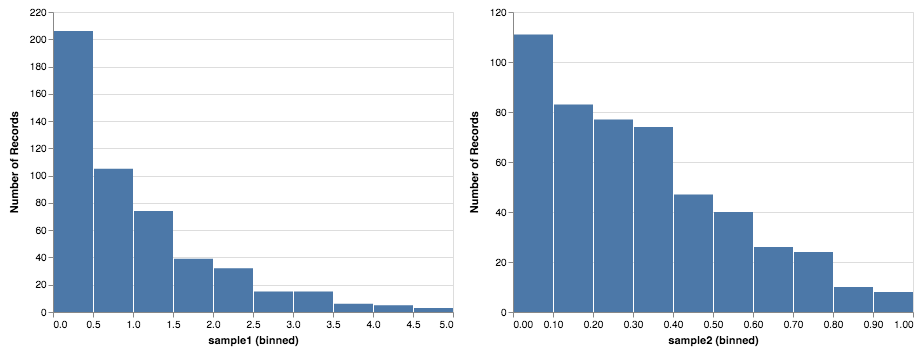

In [6]:
# Plot histograms

hist = alt.Chart(data).mark_bar()
hist1 = hist.encode(
            alt.X("sample1", bin=True),
            y='count()',
)

hist2 = hist.encode(
            alt.X("sample2", bin=True),
            y='count()',
)

hist1 | hist2

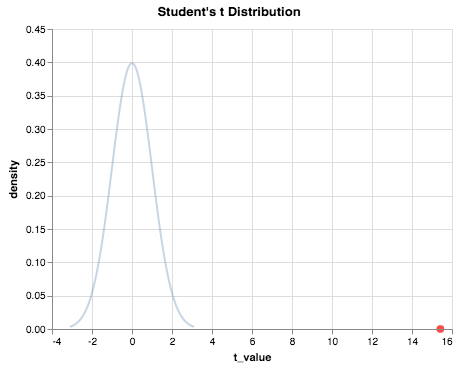

In [7]:
# Student's t test
t_value, p_value = stats.ttest_ind(sample1, sample2)
xs_student = np.linspace(stats.t.ppf(0.001, size-1), stats.t.ppf(0.999, size-1), 200)
tests = pd.DataFrame({"t_value": xs_student, "density": stats.t.pdf(xs_student, 2*size-2)})

chart = alt.Chart(tests, title="Student's t Distribution").mark_line(opacity=0.3).encode(alt.X("t_value"), alt.Y("density", scale=alt.Scale(domain=[0, 0.45])))

point_df = pd.DataFrame({"t_value": [t_value], "density": [stats.t.pdf(t_value, size-1)], "p_value": [p_value]})
point = alt.Chart(point_df).mark_circle(color="red", size=60).encode(x="t_value", y="density", tooltip="p_value")
chart + point

In [8]:
# Mann-Whitney's U (similar to Wilcoxon but for independent samples)
statistic, p_value = stats.mannwhitneyu(sample1, sample2)
print(statistic)
print(p_value)

65329.0
2.5542744550484556e-39


In [9]:
# Brunner-Munzel in dev stage in scipy
# https://scipy.github.io/devdocs/generated/scipy.stats.brunnermunzel.html

from collections import namedtuple
 
BrunnerMunzelResult = namedtuple('BrunnerMunzelResult', ('statistic','pvalue'))
 
def brunner_munzel_test(x, y, alternative="two_sided", alpha=0.5):
     
    """
    Computes the Brunner Munzel statistic
 
    Missing values in `x` and/or `y` are discarded.
 
    Parameters
    ----------
    x : sequence
        Input
    y : sequence
        Input
    alternative : {greater, less, two_sided }
 
    Returns
    -------
    statistic : float
        The Brunner Munzel  statistics
    pvalue : float
        Approximate p-value assuming a t distribution.
 
     """
    x = np.ma.asarray(x).compressed().view(np.ndarray)
    y = np.ma.asarray(y).compressed().view(np.ndarray)
    ranks = stats.rankdata(np.concatenate([x,y]))
    (nx, ny) = (len(x), len(y))
    rankx = stats.rankdata(x)
    ranky = stats.rankdata(y)
    rank_mean1 = np.mean(ranks[0:nx])
    rank_mean2 = np.mean(ranks[nx :nx+ny])
#     print(ranks)
#     print(ranks[0:nx],ranks[nx :nx+ny])
 
    pst = (rank_mean2 - (ny + 1)/2)/nx
     
    v1_set = [(i - j - rank_mean1 + (nx + 1)/2)**2 for (i,j) in zip(ranks[0:nx],rankx)]
    v2_set = [(i - j - rank_mean2 + (ny + 1)/2)**2 for (i,j) in zip(ranks[nx :nx+ny] ,ranky)]
 
    v1 = np.sum(v1_set)/(nx - 1)
    v2 = np.sum(v2_set)/(ny - 1)
    statistic = nx * ny * (rank_mean2 - rank_mean1)/(nx + ny)/np.sqrt(nx * v1 +  ny * v2)
    dfbm = ((nx * v1 + ny * v2)**2)/(((nx * v1)**2)/(nx - 1) + ((ny * v2)**2)/(ny - 1))
    if ((alternative == "greater") | (alternative == "g")) :
        prob = stats.t.cdf(statistic,dfbm)
    elif ((alternative == "less") | (alternative == "l")) :
        prob = 1-stats.t.cdf(statistic,dfbm)
    else:
        alternative = "two_sided"
        abst = np.abs(statistic)
        prob  = stats.t.cdf(abst,dfbm)
        prob= 2 * min(prob, 1-prob)
     
    return BrunnerMunzelResult(statistic,prob)

In [10]:
statistic, p_value = brunner_munzel_test(sample1, sample2)
print(statistic)
print(p_value)

-14.87259672289044
0.0
